In [10]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *
from vit_pytorch import ViT
import pandas as pd
import re
import tifffile
import torchvision
import cebra_utils

In [11]:
## First Load the models we are comparing 
sys.path.append('..')
ViT_CEBRA = torch.load('../Batch_Models/batch_trained_ViT.pth')
Masked_CEBRA = torch.load('../Batch_Models/batch_trained_Masked.pth')
MLP_CEBRA = torch.load('../Batch_Models/batch_trained_MLP.pth')

In [12]:
data_paths = [
    # '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-07-07_1',
    # '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-06-24_1',
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-06-25_1',
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-06-27_1',
]

In [13]:
def load_masks(path, min_size=50, shape=(253, 190)):
    mask_df = pd.read_csv(path)
    masks = []
    masks = []
    for index, row in mask_df.iterrows():
        mask_right = np.zeros(shape)
        mask_left = np.zeros(shape)
        right_x_coords = ast.literal_eval(row['right_x'])
        right_y_coords = ast.literal_eval(row['right_y'])
        left_x_coords = ast.literal_eval(row['left_x'])
        left_y_coords = ast.literal_eval(row['left_y'])
        left_center = ast.literal_eval(row['left_center'])
        right_pts = np.array([right_x_coords, right_y_coords]).T
        left_pts = np.array([left_x_coords, left_y_coords]).T
        ## Check if left or right is empty
        if len(right_x_coords) > 0:
            cv2.fillPoly(mask_right, np.int32([right_pts]), 1)
            masks.append(mask_right)
        if len(left_x_coords) > 0:
            cv2.fillPoly(mask_left, np.int32([left_pts]), 1)
            masks.append(mask_left)
    masks_filtered = np.array([ mask for mask in masks if np.sum(mask) > min_size])
    return masks_filtered

def load_tif(path):
    img = tifffile.imread(path)
    img = np.array(img)
    return img

def load_brain_data(parent_directory, trial_num, type='gcamp'):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/brain/' + type + '.tif')
    data = load_tif(data_path)
    return data

def load_brain_data_multi(data_paths):
    brain_data = []
    for path in data_paths:
        num_trials = len([x for x in os.listdir(path) if re.match('trial_[0-9]+$', x)]) 
        for trial_num in range(num_trials):
            brain_data.extend(load_brain_data(path, trial_num))
    return np.array(brain_data)

In [14]:
ViT_outputs = np.load('ViT_outputs.npy')
MLP_outputs = np.load('MLP_outputs.npy')
Masked_outputs = np.load('Masked_outputs.npy')
ViT_model = ViT_CEBRA.model.eval()
MLP_model = MLP_CEBRA.model.eval()
Masked_model = Masked_CEBRA.model.eval()

In [15]:
# flattened_brain_data = load_brain_data_multi(data_paths)
# num_trials = len(flattened_brain_data) // 288


# tensor_brain_data = torch.tensor(flattened_brain_data)

# with torch.no_grad():

#     for trial_num in range(num_trials):
#         tensor_brain_data_trial = tensor_brain_data[trial_num * 288:288 * (trial_num + 1)]
#         tensor_brain_data_trial = tensor_brain_data_trial.to('cuda').unsqueeze(2)
#         np.append(MLP_outputs, MLP_model(tensor_brain_data_trial.reshape(tensor_brain_data_trial.shape[0], -1)).detach().cpu().numpy(), axis=0)
#     gc.collect()
#     for trial_num in range(num_trials):
#         tensor_brain_data_trial = tensor_brain_data[trial_num * 288:288 * (trial_num + 1)]
#         square_transform = torchvision.transforms.Resize((256,256))
#         squared_trial = square_transform(tensor_brain_data_trial.squeeze()).unsqueeze(2)
#         squared_trial = squared_trial.to('cuda')
#         np.append(ViT_outputs, ViT_model(squared_trial).detach().cpu().numpy(), axis=0)
#     gc.collect()
#     for trial_num in range(num_trials):
#         tensor_brain_data_trial = tensor_brain_data[trial_num * 288:288 * (trial_num + 1)]
#         tensor_brain_data_trial = tensor_brain_data_trial.to('cuda').unsqueeze(2)
#         np.append(Masked_outputs, Masked_model(tensor_brain_data_trial).detach().cpu().numpy(), axis=0)
#     gc.collect()


#     ViT_outputs = np.array(ViT_outputs)
#     MLP_outputs = np.array(MLP_outputs)
#     Masked_outputs = np.array(Masked_outputs)

#     ## Save the outputs to a file
#     np.save('ViT_outputs.npy', ViT_outputs)
#     np.save('MLP_outputs.npy', MLP_outputs)
#     np.save('Masked_outputs.npy', Masked_outputs)

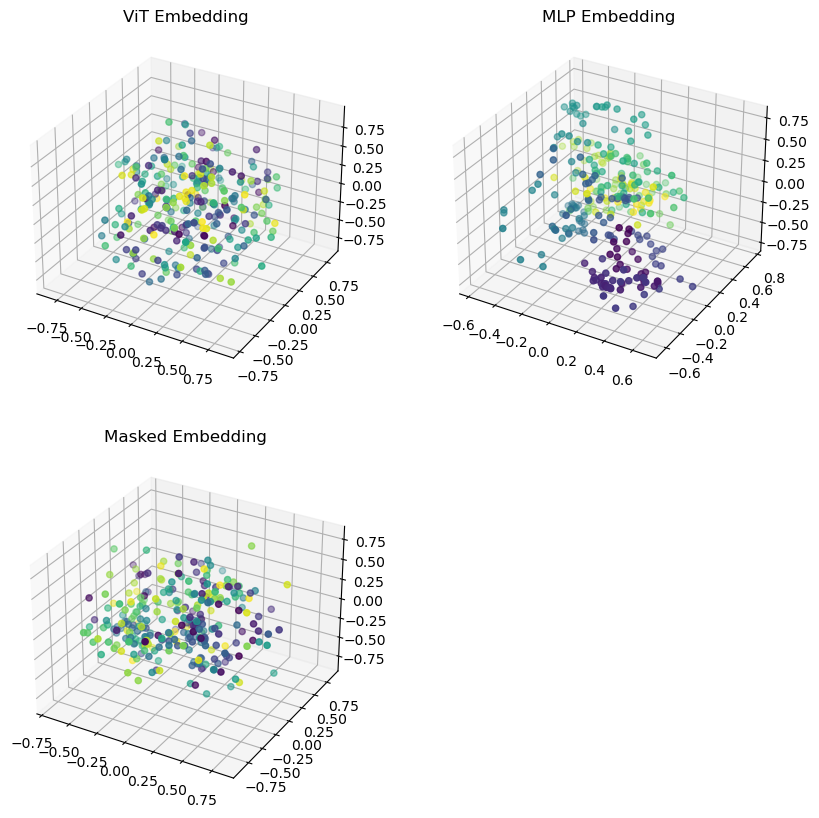

In [16]:
## Create 3 3d subplots then plot the first three dimensions of each of the embeddings
c_labels = np.arange(288)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(ViT_outputs[0:288,0], ViT_outputs[0:288,1], ViT_outputs[0:288,2], c=c_labels)
ax1.set_title('ViT Embedding')
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(MLP_outputs[0:288,0], MLP_outputs[0:288,1], MLP_outputs[0:288,2], c=c_labels)
ax2.set_title('MLP Embedding')
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(Masked_outputs[0:288,0], Masked_outputs[0:288,1], Masked_outputs[0:288,2], c=c_labels)
ax3.set_title('Masked Embedding')
plt.show()

In [17]:
from torch import nn
from x_transformers import Attention
def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

class Masked_Recorder(nn.Module):
    def __init__(self, vit, device = None):
        super().__init__()
        self.vit = vit

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output[1].pre_softmax_attn.clone().detach())

    def _register_hook(self):
        modules = find_modules(self.vit, Attention)
        for module in modules:
            handle = module.attend.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.vit

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()
        if not self.hook_registered:
            self._register_hook()

        pred = self.vit(img)

        # move all recordings to one device before stacking
        target_device = self.device if self.device is not None else img.device
        recordings = tuple(map(lambda t: t.to(target_device), self.recordings))

        attns = torch.stack(recordings, dim = 1) if len(recordings) > 0 else None
        return pred, attns

## Input is attentions maps from ViT recorder
# shape is (depth ,num_heads, num_steps, num_steps)
def rollout(attn, fusion='mean', dropout=0.0):
    # Take the mean across all heads (Subject to change)
    if fusion == 'mean':
        attn = attn.mean(dim=1)
    elif fusion == 'max':
        attn = attn.max(dim=1)[0]
    elif fusion == 'min':
        attn = attn.min(dim=1)[0]
    ## Discard lower 50% of attention
    attn[attn < torch.quantile(attn, dropout)] = 0

    # add identity adn normalize
    residual_attn = torch.eye(attn.shape[-1]).unsqueeze(0).to('cpu') + attn
    residual_attn = residual_attn / residual_attn.sum(dim=-1).unsqueeze(-1)
    # convert to numpy
    aug_attn_mat = residual_attn.detach().cpu().numpy()
    #Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    return v[0, 1:]



In [18]:
from recorder import Recorder
device = 'cuda'

model = Masked_model.to(device)
model.eval()
masked_recorder = Masked_Recorder(model, device=device)

model = ViT_model.to(device)
model.eval()
model = [child2 for child2 in [child for child in model.children()][0].children()][0]
ViT_recorder = Recorder(model, device=device)


def get_attn_maps_masked(recorder, brain_data, device='cuda'):

    with torch.no_grad():
        pred, attn = recorder(brain_data)
    attention_mapping = np.array([rollout(map.to('cpu'), fusion='max', dropout=0.3) for map in attn])
    masks = [x.get_masks() for x in recorder.modules() if isinstance(x, cebra_utils.masked_reduction_layer)][0]
    attention_map = np.sum(masks * np.expand_dims(attention_mapping, [2,3]), axis=1)
    return attention_map

def get_attn_maps_ViT(recorder, brain_data, device='cuda'):

    with torch.no_grad():
        pred, attn = recorder(brain_data)
    attention_mapping = np.array([rollout(map.to('cpu'), fusion='max', dropout=0.3) for map in attn])
    grid_size = int(np.sqrt(attention_mapping.shape[-1]))
    masks = [mask.reshape(grid_size, grid_size) for mask in attention_mapping]
    return masks


In [19]:
# trial_num = 2
# tensor_brain_data_trial = tensor_brain_data[trial_num:(trial_num + 1) * 288].unsqueeze(2).to('cuda')
# squared_trial = square_transform(tensor_brain_data_trial.squeeze()).unsqueeze(1).to('cuda')

# attn_maps_masked = get_attn_maps_masked(masked_recorder, tensor_brain_data_trial)
# attn_maps_ViT = get_attn_maps_ViT(ViT_recorder, squared_trial)

# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(221)
# ax1.imshow(np.mean(attn_maps_masked, axis=0))
# ax1.set_title('Mean Masked Attention Map')
# ax2 = fig.add_subplot(222)
# ax2.imshow(cv2.resize(np.mean(attn_maps_ViT, axis=0), (256, 256)))
# ax2.imshow(np.max(squared_trial.squeeze().cpu().numpy(), axis=0), alpha=0.5, cmap='gray')
# ax2.set_title('Mean ViT Attention Map')
# plt.show()

In [20]:
outcome_paths = [
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-07-07_1.csv',
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-06-24_1.csv',
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-06-25_1.csv',
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-06-27_1.csv',
]
success = []

for path in outcome_paths:
    outcome_data = pd.read_csv(path)

    ## if outcome contains 's' append one to success array  else append 0 to success array
    try:
        outcomes = outcome_data['Outcome']
    except:
        try:
            outcomes = outcome_data['outcome']
        except:
            outcomes = outcome_data['outcomes']
    # repkace all nan with None
    outcomes = [x if x is not np.nan else None for x in outcomes]

    for outcome in outcomes:
        if outcome is not None:
            outcome_split = outcome[1:-1].split(',')
            if 'ws' in outcome_split:
                success.append([1, 0])
            else:
                success.append([0, 1])
        else:
            success.append([0, 1])

In [21]:
## reshape vit outputs to be (num_trials, num_steps, num_features)
num_trials = len(ViT_outputs) // 288
ViT_outputs = ViT_outputs.reshape(num_trials, 288, -1)
MLP_outputs = MLP_outputs.reshape(num_trials, 288, -1)
Masked_outputs = Masked_outputs.reshape(num_trials, 288, -1)

In [39]:
## Load a simple LSTM model which takes in an embedding vector (288 x 8) and classifies it as success or failure
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.hidden = self.init_hidden()
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to('cuda'),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to('cuda'))
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        out = self.fc(lstm_out[:, -1, :])
        return out
    def reset_weights(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
    
vit_classifier = LSTM(8, 64, 2, 1)
mask_classifier = LSTM(8, 64, 2, 1)
mlp_classifier = LSTM(8, 64, 2, 1)
vit_classifier = vit_classifier.to('cuda')
mlp_classifier = mlp_classifier.to('cuda')
mask_classifier = mask_classifier.to('cuda')

## Evaluates the accuracy of a Model given a batch of data and labels
# @param model: model to evaluate
# @param batch: batch of data to evaluate
# @param labels: labels for the batch of data
# @return predictions: predictions for the batch of data and the accuracy of the model
def evaluate_model(model, batch, labels):
    model.eval()
    predictions = []
    correct = 0
    for i in range(len(batch)):
        model.hidden = model.init_hidden()
        prediction = (model(torch.from_numpy(batch[i]).float().unsqueeze(0).to('cuda')).detach().cpu().numpy())
        # argmax to get the prediction
        predictions.append(np.argmax(prediction))
        if np.argmax(prediction) == np.argmax(labels[i]):
            correct += 1
    return correct / len(batch), predictions

def evaluate_model_fully_connected(model, batch, labels):
    model.eval()
    predictions = []
    for i in range(len(batch)):
        prediction = (model(torch.from_numpy(batch[i]).float().reshape(-1).to('cuda')).detach().cpu().numpy())
        predictions.append(np.argmax(prediction))
    correct = np.sum(np.array(predictions) == np.argmax(labels, axis=1))


    return correct / len(predictions), predictions

def train_model(classifier, optimizer, batch_data, success_data, num_epochs, train_indices, test_batch, test_success, criterion):
    log = []
    accuracy = []
    ## Schedule learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    for i in range(num_epochs):
        classifier.train()
        avg_loss = 0
        loss = torch.tensor(0).to('cuda').float()
        for j in train_indices:
            optimizer.zero_grad()
            classifier.hidden = classifier.init_hidden()
            outputs = classifier(torch.from_numpy(batch_data[j]).float().unsqueeze(0).to('cuda'))
            loss += criterion(outputs, torch.tensor([success_data[j]]).to('cuda').float())
            avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        avg_loss = avg_loss / len(train_indices)
        log.append(avg_loss)
        accuracy_val, predictions = evaluate_model(classifier, test_batch, test_success)
        accuracy.append(accuracy_val)
        print('\rEpoch: ', i, 'Loss: ' , avg_loss, 'Validation Accuracy: ' + str(accuracy_val)[:5], end='')
    return log, accuracy

## Instead of using a LSTM model we use fully connected layers over all embeddings
class FullyConnected(nn.Module):
    def __init__(self, embedding_size, session_size, num_hidden, num_classes, num_layers=2):
        super(FullyConnected, self).__init__()
        self.embedding_size = embedding_size
        self.session_size = session_size
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.fc1 = nn.Linear(self.embedding_size * self.session_size, self.num_hidden)
        for i in range(self.num_layers - 1):
            setattr(self, 'fc' + str(i + 2), nn.Linear(self.num_hidden, self.num_hidden))
            ## add dropout
            setattr(self, 'dropout' + str(i + 2), nn.Dropout(p=0.5))
        self.fc_out = nn.Linear(self.num_hidden, self.num_classes)

    def forward(self, x):
        x = x.view(-1, self.embedding_size * self.session_size)
        x = F.relu(self.fc1(x))
        for i in range(self.num_layers - 1):
            x = F.relu(getattr(self, 'fc' + str(i + 2))(x))
            x = getattr(self, 'dropout' + str(i + 2))(x)
        x = self.fc_out(x)
        return x
      


def train_model_fully_connected(classifier, optimizer, batch_data, success_data, num_epochs, train_indices, test_batch, test_success, criterion):
    log = []
    accuracy = []
    ## Schedule learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    for i in range(num_epochs):
        classifier.train()
        avg_loss = 0
        loss = torch.tensor(0).to('cuda').float()
        train_indices = np.array(train_indices)
        success_data = np.array(success_data)
        train_batch = batch_data[train_indices]
        success_batch = success_data[train_indices]
        optimizer.zero_grad()
        outputs = classifier(torch.from_numpy(train_batch).float().reshape(-1).to('cuda'))
        loss += criterion(outputs, torch.tensor(success_batch).to('cuda').float())
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        avg_loss = avg_loss / len(train_indices)
        log.append(avg_loss)
        accuracy_val, predictions = evaluate_model_fully_connected(classifier.eval(), test_batch, test_success)
        accuracy.append(accuracy_val)
        print('\rEpoch: ', i, 'Loss: ' , avg_loss, 'Validation Accuracy: ' + str(accuracy_val)[:5], end='')
    return log, accuracy


# Training loop for LSTM using k-fold cross validation
num_epochs = 70
k_folds = 5
test_splits = [i/k_folds for i in range(k_folds)]
test_splits.append(1)
criterion = nn.CrossEntropyLoss()
lr_vit = 1e-3
lr_masked = 1e-3
lr_mlp = 1e-3

# Create an array of indices to split the data into train and test
length = len(ViT_outputs)
indices = np.arange(len(ViT_outputs))
# use same seed
# np.random.seed(1101)
# np.random.shuffle(indices)
vit_log = []
vit_accuracy = []
mlp_log = []
mlp_accuracy = []
masked_log = [] 
masked_accuracy = []
# Split the data into train and test

## model parameters
embedding_size = 8
session_size = 288
num_hidden = 1024
num_classes = 2
num_layers = 4

for i in range(k_folds):
    test_indices = indices[int(test_splits[i] * length ):int(test_splits[i+1] * (length))]
    train_indices = np.delete(indices, test_indices)
    test_ViT_outputs = ViT_outputs[test_indices]
    test_MLP_outputs = MLP_outputs[test_indices]
    test_masked_outputs = Masked_outputs[test_indices]
    test_success = np.array(success)[test_indices]
    
    # Train vit classifier
    vit_classifier = FullyConnected(
        embedding_size=embedding_size,
        session_size=session_size,
        num_hidden=num_hidden,
        num_classes=num_classes,
        num_layers=num_layers
    ).to('cuda')
    optimizer_vit = torch.optim.Adam(vit_classifier.parameters(), lr=lr_vit)
    vit_log_temp, vit_accuracy_temp = train_model_fully_connected(vit_classifier, optimizer_vit, ViT_outputs, success, num_epochs, train_indices, test_ViT_outputs, test_success, criterion)
    vit_log.extend(vit_log_temp)
    vit_accuracy.extend(vit_accuracy_temp)
    print('\n Final ViT Accuracy: ', vit_accuracy[-1])

    # Train mlp classifier
    mlp_classifier = FullyConnected(
        embedding_size=embedding_size,
        session_size=session_size,
        num_hidden=num_hidden,
        num_classes=num_classes,
        num_layers=num_layers
    ).to('cuda')
    optimizer_mlp = torch.optim.Adam(mlp_classifier.parameters(), lr=lr_mlp)
    mlp_log_temp, mlp_accuracy_temp = train_model_fully_connected(mlp_classifier, optimizer_mlp, MLP_outputs, success, num_epochs, train_indices, test_MLP_outputs, test_success, criterion)
    mlp_log.extend(mlp_log_temp)
    mlp_accuracy.extend(mlp_accuracy_temp)
    print('\n Final MLP Accuracy: ', mlp_accuracy[-1])

    # Train masked classifier
    mask_classifier = FullyConnected(
        embedding_size=embedding_size,
        session_size=session_size,
        num_hidden=num_hidden,
        num_classes=num_classes,
        num_layers=num_layers
    ).to('cuda')
    optimizer_mask = torch.optim.Adam(mask_classifier.parameters(), lr=lr_masked)
    masked_log_temp, masked_accuracy_temp = train_model_fully_connected(mask_classifier, optimizer_mask, Masked_outputs, success, num_epochs, train_indices, test_masked_outputs, test_success, criterion)
    masked_log.extend(masked_log_temp)
    masked_accuracy.extend(masked_accuracy_temp)
    print('\n Final Masked Accuracy: ', masked_accuracy[-1])
    


Epoch:  69 Loss:  0.0 Validation Accuracy: 0.666on Accuracy: 0.7549
 Final ViT Accuracy:  0.6666666666666666
Epoch:  69 Loss:  1.374619992712605e-10 Validation Accuracy: 0.7719
 Final MLP Accuracy:  0.7719298245614035
Epoch:  69 Loss:  0.0 Validation Accuracy: 0.631ion Accuracy: 0.491
 Final Masked Accuracy:  0.631578947368421
Epoch:  69 Loss:  8.498787950805348e-07 Validation Accuracy: 0.6666
 Final ViT Accuracy:  0.6666666666666666
Epoch:  69 Loss:  3.225941920549224e-08 Validation Accuracy: 0.7712
 Final MLP Accuracy:  0.7719298245614035
Epoch:  69 Loss:  4.822395159526818e-10 Validation Accuracy: 0.6144
 Final Masked Accuracy:  0.6140350877192983
Epoch:  69 Loss:  9.092829352152181e-12 Validation Accuracy: 0.6891
 Final ViT Accuracy:  0.6896551724137931
Epoch:  69 Loss:  2.2676981862036583e-07 Validation Accuracy: 0.879
 Final MLP Accuracy:  0.8793103448275862
Epoch:  69 Loss:  2.6571947631067e-09 Validation Accuracy: 0.793930
 Final Masked Accuracy:  0.7931034482758621
Epoch:  69 

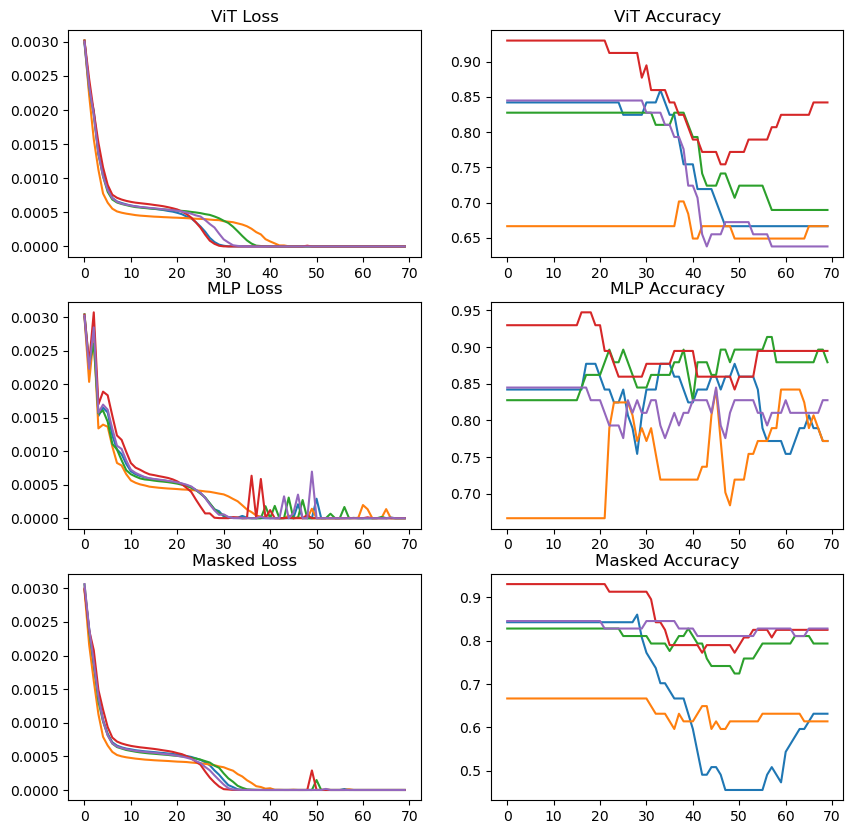

In [40]:
# plot both losses on the same graph
vit_log = np.array(vit_log).reshape(k_folds, num_epochs)
mlp_log = np.array(mlp_log).reshape(k_folds, num_epochs)
masked_log = np.array(masked_log).reshape(k_folds, num_epochs)
vit_accuracy = np.array(vit_accuracy).reshape(k_folds, num_epochs)
mlp_accuracy = np.array(mlp_accuracy).reshape(k_folds, num_epochs)
masked_accuracy = np.array(masked_accuracy).reshape(k_folds, num_epochs)
## Create two plots, one for each model
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
# plot all the losses

axs[0, 0].plot((vit_log).T)
axs[1, 0].plot((mlp_log).T)
axs[2, 0].plot((masked_log).T)
axs[0, 1].plot((vit_accuracy).T)
axs[1, 1].plot((mlp_accuracy).T)
axs[2, 1].plot((masked_accuracy).T)
axs[0, 0].set_title('ViT Loss')
axs[1, 0].set_title('MLP Loss')
axs[2, 0].set_title('Masked Loss')
axs[0, 1].set_title('ViT Accuracy')
axs[1, 1].set_title('MLP Accuracy')
axs[2, 1].set_title('Masked Accuracy')
plt.show()
